In [3]:
import pandas as pd
import os
import json
import src.DevicePreprocessor
import src.DPKMeans
import src.kmeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split




In [5]:
# Load parameters
with open("../../config/run.json") as fh:
    params = json.load(fh)
kmeans_params = params.get("kmeans-params")
k = kmeans_params.get('k') 
epsilon = kmeans_params.get('epsilon')  
tau = kmeans_params.get('tau') 
parquet_path = kmeans_params.get('parquet_path')
output_parquet_path = kmeans_params.get('output_parquet_path')
output_cluster_path = kmeans_params.get('output_cluster_path')

cwd = os.getcwd()


In [7]:

# Data Preprocessing
def preprocess_data(cwd, parquet_path, output_parquet_path):
    count_parameter = 10  # Originally 10000 in paper
    parquet_path = os.path.join(cwd,"..","..", parquet_path)
    output_parquet_path = 'synthetic_out.parquet'
    
    analysis = src.DevicePreprocessor.DevicePreprocessor(
        parquet_file=parquet_path, 
        output_parquet_path=output_parquet_path,
        count_parameter=count_parameter
    )
    analysis.preprocess()
    df = pd.read_parquet(output_parquet_path)
    data = pd.DataFrame(df["l1_distance"])
    os.remove(output_parquet_path)
    
    scaler = MinMaxScaler(feature_range=(-10, 10))
    data = scaler.fit_transform(data)
    return data

data = preprocess_data(cwd, parquet_path, output_parquet_path)



Compute baseline non-private kmeans loss

In [11]:

# Compute KMeans Loss
def compute_kmeans_loss(data, k, test_size, random_seed):
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=random_seed)
    kmeans = src.kmeans.KMeans(k)
    kmeans.fit(train_data)
    train_loss = kmeans.compute_inertia(train_data) / train_data.shape[0]
    test_loss = kmeans.compute_inertia(test_data) / test_data.shape[0]
    return train_loss, test_loss

test_size = 0.2
random_seed = 42
train_loss, test_loss = compute_kmeans_loss(data, k, test_size, random_seed)



Compute dp-kmeans loss (inertia) across different epsilon

In [20]:
# Compute DP-KMeans Inertia
def compute_dpkmeans_inertia(data, k, epsilons, tau):
    inertias = []
    for eps in epsilons:
        dp_kmeans = src.DPKMeans.DPKMeans(k=k, eps=eps, tau=tau, iterations=10)
        dp_kmeans.fit(data)
        inertia = dp_kmeans.compute_inertia(data) / data.shape[0]
        inertias.append(inertia)
    
    return inertias

epsilons = np.logspace(-2, 2, 100)
np.random.seed(random_seed)
inertias = compute_dpkmeans_inertia(data, k, epsilons, tau)



Plot results

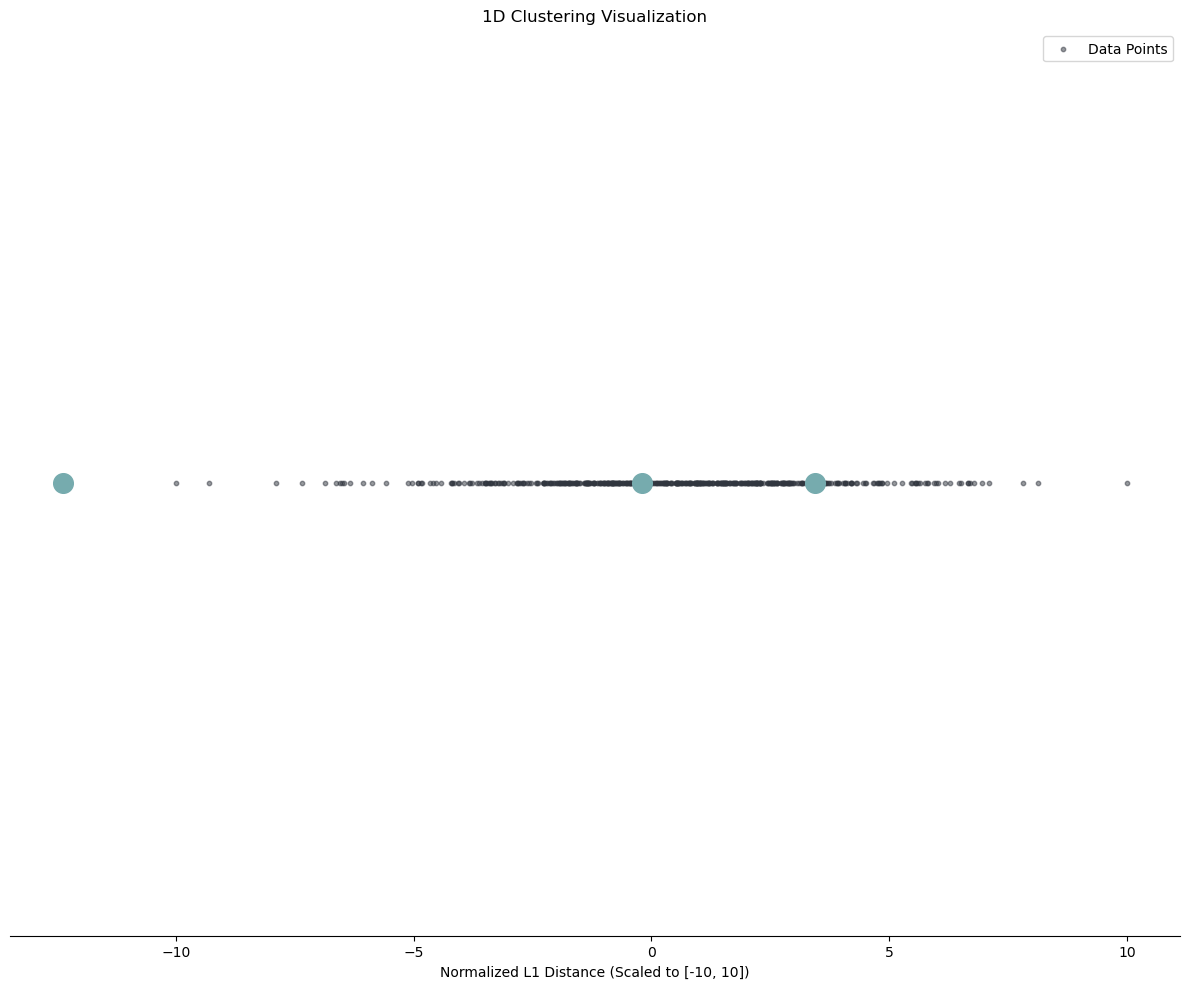

In [27]:
# Train DP-KMeans and Plot Clusters
mod = src.DPKMeans.DPKMeans(k=k, eps=epsilon, tau=tau, iterations=10)
mod.fit(data)
cluster_centers = mod.centroids.flatten()

def plot_1d_clusters(data, cluster_centers, output_path):
    plt.figure(figsize=(12, 10))
    plt.scatter(data, np.zeros_like(data), color="#31363F", alpha=0.5, s=10, label="Data Points")
    for center in cluster_centers:
        plt.scatter(center, 0, color="#76ABAE", marker='o', s=200)
    plt.yticks([])
    plt.grid(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.xlabel("Normalized L1 Distance (Scaled to [-10, 10])")
    plt.title("1D Clustering Visualization")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_1d_clusters(data, cluster_centers, os.path.join(cwd, output_cluster_path))



Plot results comparing dp-kmeans to baseline kmeans

In [23]:
def plot_results(cwd, epsilons, inertias, train_loss, test_loss):
    """Plot and save the DP-KMeans inertia along with train and test loss."""
    gray_line_color = "#31363F"  
    train_loss_color = "#76ABAE" 
    test_loss_color = "#222831"  

    plt.figure(figsize=(12, 6))
    plt.plot(epsilons, inertias, marker='o', linestyle='-', color=gray_line_color, label='DP-KMeans Inertia')
    plt.axhline(y=train_loss, color=train_loss_color, linestyle='--', label='Train Loss ' + str(round(train_loss, 2)))
    plt.axhline(y=test_loss, color=test_loss_color, linestyle='--', label='Test Loss ' + str(round(test_loss, 2)))

    plt.xlabel("Epsilon")
    plt.xscale('log')
    plt.ylabel("Inertia")
    plt.title("Effect of Epsilon on DP-KMeans Avg Inertia")
    plt.legend()
    plt.grid(True, color="#EEEEEE")
    
    plt.show()

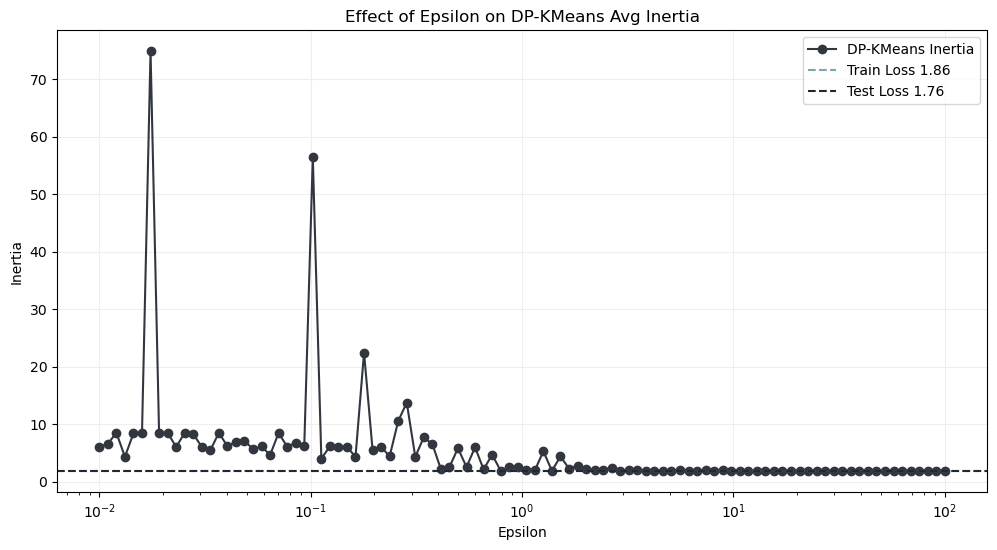

In [24]:
plot_results(cwd, epsilons, inertias, train_loss, test_loss)


Plot for different tau values

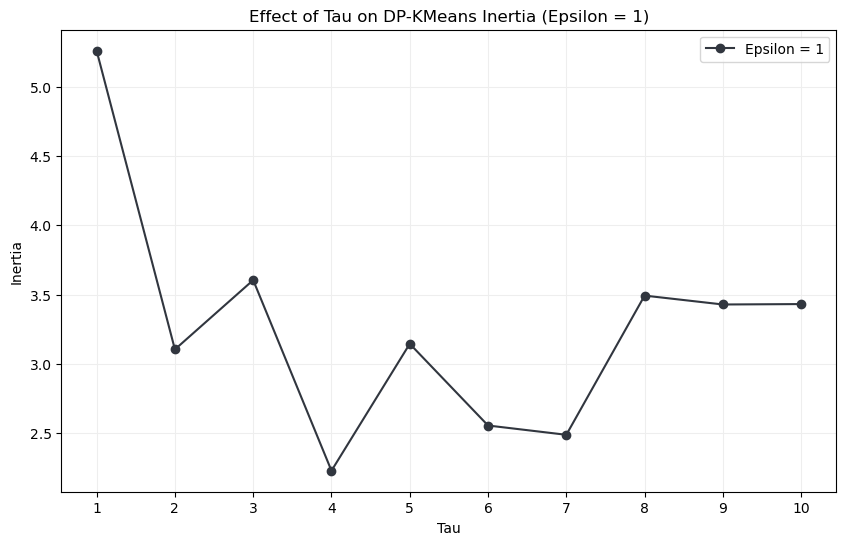

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results_tau_fixed_epsilon(tau_range, epsilon, data, k):
    """Plot DP-KMeans inertia for different tau values while keeping epsilon fixed."""
    inertias = []
    
    for tau in tau_range:
        dp_kmeans = src.DPKMeans.DPKMeans(k=k, eps=epsilon, tau=tau, iterations=10)
        dp_kmeans.fit(data)
        inertia = dp_kmeans.compute_inertia(data) / data.shape[0]
        inertias.append(inertia)
    

    plt.figure(figsize=(10, 6))
    plt.plot(tau_range, inertias, marker='o', linestyle='-', color="#31363F", label=f"Epsilon = {epsilon}")

    plt.xlabel("Tau")
    plt.ylabel("Inertia")
    plt.title(f"Effect of Tau on DP-KMeans Inertia (Epsilon = {epsilon})")
    plt.xticks(tau_range)
    plt.legend()
    plt.grid(True, color="#EEEEEE")
    
    plt.show()

tau_range = np.arange(1, 11)  # Tau values from 1 to 10
epsilon = 1  # Fix epsilon at 1
plot_results_tau_fixed_epsilon(tau_range, epsilon, data, k)
